In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

sns.set(style='whitegrid')
import matplotlib
matplotlib.rcParams["figure.dpi"] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

In [2]:
import sys 
sys.path.append('../')

In [3]:

import os
import numpy as np
import torch
import torch.nn as nn
import wandb
import pytorch_lightning as pl

import tqdm
import pickle
from torch.utils.data import IterableDataset, DataLoader
from models import TransactionsModel
from data_generators import batches_generator, cat_features_names, num_features_names, meta_features_names

from functools import partial
from collections import namedtuple
from tools import make_time_batch, calculate_embedding_size
from transformers import AutoTokenizer,  AutoModelForSeq2SeqLM, T5Tokenizer, T5Model, T5ForConditionalGeneration, Adafactor, AutoConfig

Extension horovod.torch has not been built: /home/user/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/home/user/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` i

In [4]:
with open('./assets/num_embedding_projections.pkl', 'rb') as f:
    num_embedding_projections = pickle.load(f)
    
with open('./assets/cat_embedding_projections.pkl', 'rb') as f:
    cat_embedding_projections = pickle.load(f)

with open('./assets/meta_embedding_projections.pkl', 'rb') as f:
    meta_embedding_projections = pickle.load(f)
    
path_to_dataset = '/home/jovyan/data/train_buckets'

dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])

valpath_to_dataset = '/home/jovyan/data/val_buckets'

valdir_with_datasets = os.listdir(valpath_to_dataset)
dataset_val = sorted([os.path.join(valpath_to_dataset, x) for x in valdir_with_datasets])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# !pip install inflect

### Debugging

In [221]:
for param in model_transaction.parameters():
    param.requires_grad = False

In [ ]:
params = list(model.parameters()) + list(linear_mapping.parameters())

In [223]:
optimizer = torch.optim.Adam(params, lr=1e-5)

In [224]:
def pad_outputs(lst, tok):
    if len(lst) == 2:
        lst.append(tok.pad_token_id)
    
    return lst

In [230]:
# wandb.init(pembed_tokensect="romashka", entity="serofade", group='tqa')
starting = tok.encode("this is the client's transaction history", return_tensors='pt').cuda()

number_of_days = np.random.choice(train_days.numpy())
tokenized_days = tok.encode(str(number_of_days), return_tensors='pt').cuda()

embedding_starting = model.encoder.embed_tokens(tokenized_days)

batch_size = batch['mask'].shape[0]
    
embedding_starting_necessary = embedding_starting.repeat(batch_size, 1, 1)
ending = tok.encode(f"how many transactions it will make in {number_of_days} days", return_tensors='pt').cuda()
embedding_ending = model.encoder.embed_tokens(tokenized_days).repeat(batch_size, 1, 1)

_, labels, _, padding_mask = make_time_batch(batch, number_days=number_of_days)

padding_min = max(1, padding_mask.sum(1).min().item())

In [231]:
answer_ending = tok.encode('client will make', return_tensors='pt')[:, :-1].cuda().repeat(batch_size, 1)
answer_mask = torch.ones(batch_size, 3).cuda()

In [232]:
answer_ending.shape

torch.Size([2, 3])

In [233]:
# if padding_min == 1:
#     continue

# for i, batch in tqdm.tqdm(enumerate(train_dataloader)):
for i in range(10000):
     
    out = linear_mapping(model_transaction.get_embs(batch)[0])
    encoder_input =  out[:, padding_min-1:padding_min]

    rly_encoder_input = torch.cat([embedding_starting_necessary, encoder_input, embedding_ending], dim=1)
    input_labels = labels[:, padding_min - 1]
    target = tok.batch_encode_plus(list(map(lambda x: str(x.item()), input_labels.int())), padding=True, return_tensors='pt')
    
    torch_labels = target.input_ids.cuda()
    attention_mask = target.attention_mask.cuda()
    
    answer = torch.cat([answer_ending, torch_labels], dim=1)
    decoder_mask = torch.cat([answer_mask, attention_mask], dim=1)
    # rly_encoder_input = torch.cat([encoder_input, day_prefix], dim=1).repeat(padding_min, 1, 1)  
    # torch_labels = torch.tensor(list(map(lambda x: pad_outputs(tok.encode(str(x.int().item())), tok), labels.int()[:, :padding_min].reshape(-1)))).cuda()
    
    # break
    
#     attention_mask = torch.triu(torch.ones(padding_min, padding_min+2)).repeat(batch_size, 1).cuda()
    
    outputs = model(inputs_embeds=rly_encoder_input, labels=answer, decoder_attention_mask=decoder_mask)
    loss = outputs.loss
    
    loss.backward(retain_graph=True)
    
    optimizer.step()
    
    if i % 100 == 0 and i != 0:
        # wandb.log({'train_loss': loss.item()})
        print(loss.item())
    
# wandb.finish()

0.16760709881782532
0.006415157113224268


KeyboardInterrupt: 

In [234]:
tok.batch_decode(outputs.logits.argmax(2))

['client will make 32</s>', 'client will make 33</s>']

In [235]:
number_of_days

30

In [236]:
input_labels

tensor([32., 33.], device='cuda:0')

In [132]:
for i, elem in enumerate(torch_labels[:, 0]):
    print(elem, outputs.logits[i, 0, elem])

tensor(460, device='cuda:0') tensor(-9.5558, device='cuda:0', grad_fn=<SelectBackward>)
tensor(11526, device='cuda:0') tensor(-11.9299, device='cuda:0', grad_fn=<SelectBackward>)


In [133]:
outputs.logits.argmax(2)

tensor([[1188,   56,   36, 2838,    1],
        [1188,   56,   36, 2838,    1]], device='cuda:0')

In [134]:
torch.topk(outputs.logits, 5).indices

tensor([[[1188, 2838,  820,    8,    3],
         [  56,   19, 2838,    3,   65],
         [  36,   59,  726,   43,  143],
         [2838,    3,    8,   46, 1942],
         [   1,  770, 1093,    3,  399]],

        [[1188, 2838,  820,    8,    3],
         [  56, 2838,   19,    3,   47],
         [  36,  726,   59,   43,  129],
         [2838,    3,    8,   46, 1942],
         [   1,  770,    3, 4364,    5]]], device='cuda:0')

In [136]:
k = 0

print(input_labels[k].item())
for i in range(1, 25):
    print(i, outputs.logits[k, 0, tok.encode(str(i))[0]])

20.0
1 tensor(-6.8242, device='cuda:0', grad_fn=<SelectBackward>)
2 tensor(-6.3647, device='cuda:0', grad_fn=<SelectBackward>)
3 tensor(-7.7969, device='cuda:0', grad_fn=<SelectBackward>)
4 tensor(-8.5440, device='cuda:0', grad_fn=<SelectBackward>)
5 tensor(-8.3946, device='cuda:0', grad_fn=<SelectBackward>)
6 tensor(-11.4399, device='cuda:0', grad_fn=<SelectBackward>)
7 tensor(-11.5413, device='cuda:0', grad_fn=<SelectBackward>)
8 tensor(-11.2431, device='cuda:0', grad_fn=<SelectBackward>)
9 tensor(-10.1065, device='cuda:0', grad_fn=<SelectBackward>)
10 tensor(-10.4598, device='cuda:0', grad_fn=<SelectBackward>)
11 tensor(-10.9918, device='cuda:0', grad_fn=<SelectBackward>)
12 tensor(-10.6879, device='cuda:0', grad_fn=<SelectBackward>)
13 tensor(-9.8635, device='cuda:0', grad_fn=<SelectBackward>)
14 tensor(-10.0260, device='cuda:0', grad_fn=<SelectBackward>)
15 tensor(-10.2711, device='cuda:0', grad_fn=<SelectBackward>)
16 tensor(-10.0164, device='cuda:0', grad_fn=<SelectBackward>)
17

In [268]:
# for i, elem in enumerate(torch_labels[:, 0]):
#     print(elem, outputs.logits[i, 0, elem])

In [317]:
for i in range(1, 100):
    print(i, len(tok.encode(str(i))),  tok.encode(str(i))[0])

1 2 209
2 2 204
3 2 220
4 2 314
5 2 305
6 2 431
7 2 489
8 2 505
9 2 668
10 2 335
11 2 850
12 2 586
13 2 1179
14 2 968
15 2 627
16 2 898
17 2 1003
18 2 507
19 2 957
20 2 460
21 2 1401
22 2 1630
23 2 1902
24 2 997
25 2 944
26 2 2208
27 2 2307
28 2 2059
29 2 2838
30 2 604
31 2 2664
32 2 3538
33 2 5400
34 2 6154
35 2 3097
36 2 4475
37 2 6862
38 2 6654
39 2 6352
40 2 1283
41 2 8798
42 2 6426
43 2 8838
44 2 8537
45 2 3479
46 2 9668
47 2 10635
48 2 4678
49 2 9526
50 2 943
51 2 11696
52 2 9065
53 2 12210
54 2 10630
55 2 6897
56 2 11526
57 3 3
58 3 3
59 3 3
60 2 1640
61 3 3
62 3 3
63 3 3
64 2 6687
65 2 7123
66 3 3
67 3 3
68 3 3
69 3 3
70 2 2861
71 3 3
72 2 9455
73 3 3
74 3 3
75 2 6374
76 3 3
77 3 3
78 3 3
79 3 3
80 2 2775
81 3 3
82 3 3
83 3 3
84 3 3
85 2 11989
86 3 3
87 3 3
88 3 3
89 3 3
90 2 2777
91 3 3
92 3 3
93 3 3
94 3 3
95 2 11923
96 3 3
97 3 3
98 3 3
99 2 12185


In [518]:
with torch.no_grad():
    model.eval()
    model_transaction.eval()
    
    batch_size = batch['mask'].shape[0]
    
    number_of_days = np.random.choice(train_days.numpy())
    tokenized_days = tok.encode(str(number_of_days), return_tensors='pt').cuda()
    day_prefix = model.encoder.embed_tokens(tokenized_days).repeat(batch_size, 1, 1)
    
    _, labels, _, padding_mask = make_time_batch(batch, number_days=30)
    
    padding_min = max(1, padding_mask.sum(1).min().item())
        
    out = linear_mapping(model_transaction.get_embs(batch)[0])
    encoder_input =  out[:, :padding_min]

    rly_encoder_input = torch.cat([encoder_input, day_prefix], dim=1).repeat(padding_min, 1, 1)  
    torch_labels = torch.tensor(list(map(lambda x: pad_outputs(tok.encode(str(x.int().item())), tok), labels.int()[:, :padding_min].reshape(-1)))).cuda()
    
    attention_mask = torch.triu(torch.ones(padding_min, padding_min+2)).repeat(batch_size, 1).cuda()
    
    outputs = model(inputs_embeds=rly_encoder_input, labels=torch_labels)
    loss = outputs.loss

### Full version

In [392]:
ckpt = torch.load('/home/jovyan/romashka/wandb/run-20230222_133923-dhkmskss/files/checkpoints/final_model.ckpt')

model_transaction = TransactionsModel(cat_embedding_projections,
                          cat_features_names,
                          num_embedding_projections,
                          num_features_names,
                          meta_embedding_projections,
                          meta_features_names,
                          encoder_type='whisper/tiny',
                          head_type='next',
                          embedding_dropout=0.1
                         )
model_transaction.load_state_dict(ckpt)
model_transaction.cuda();

USING whisper


In [393]:
linear_mapping = nn.Linear(384, 512).cuda()

In [394]:
tok = AutoTokenizer.from_pretrained('google/flan-t5-small')
model = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-small').cuda()

In [395]:
train_dataloader = batches_generator(dataset_train, batch_size=16, shuffle=True,
                                            device=device, is_train=True, output_format='torch',  min_seq_len=100, max_seq_len=300)

batch = next(iter(train_dataloader))

In [396]:
# for param in model.parameters():
#     param.requires_grad = False

In [397]:
params = list(model.parameters()) + list(linear_mapping.parameters())  + list(model_transaction.parameters())

In [398]:
optimizer = torch.optim.AdamW(params, lr=1e-5)

In [399]:
def pad_outputs(lst, tok):
    if len(lst) == 2:
        lst.append(tok.pad_token_id)
    
    return lst

In [415]:
# wandb.init(pembed_tokensect="romashka", entity="serofade", group='tqa')
number_of_days = np.random.choice(train_days.numpy())

starting = tok.encode("this is the client's transaction history", return_tensors='pt').cuda()
question = tok.encode(f"how many transactions the client will make in the next {number_of_days} days", return_tensors='pt').cuda()
answer_ending = tok.encode('the client will make', return_tensors='pt')[:, :-1].cuda()

In [554]:
input_labels

tensor([ 9., 10.,  9., 11., 22., 39., 11., 31.], device='cuda:0')

In [551]:
tok.batch_decode(answer)

['the client will make 9 transactions</s>',
 'the client will make 10 transactions</s>',
 'the client will make 9 transactions</s>',
 'the client will make 11 transactions</s>',
 'the client will make 22 transactions</s>',
 'the client will make 39 transactions</s>',
 'the client will make 11 transactions</s>',
 'the client will make 31 transactions</s>']

In [420]:
for epoch in range(10):
    for i, batch in tqdm.tqdm(enumerate(train_dataloader), position=0):
# for _ in range(1):
#     for i in tqdm.tqdm(range(10000), position=0):
        number_of_days = np.random.choice(train_days.numpy())
        question = tok.encode(f"how many transactions the client will make in the next {number_of_days} days", return_tensors='pt').cuda()
        embedding_prefix = model.encoder.embed_tokens(starting)
        embedding_question = model.encoder.embed_tokens(question)

        batch_size = batch['mask'].shape[0]

        batch_embedding_prefix = embedding_prefix.repeat(batch_size, 1, 1)
        batch_embedding_question = embedding_question.repeat(batch_size, 1, 1)
        batch_answer_ending = answer_ending.repeat(batch_size, 1)

        answer_mask = torch.ones(batch_size, answer_ending.shape[1]).cuda()

        _, labels, _, padding_mask = make_time_batch(batch, number_days=number_of_days)
        padding_min = max(1, padding_mask.sum(1).min().item())

        if padding_min == 1:
            continue

        out = linear_mapping(model_transaction.get_embs(batch)[0])
        encoder_input = out[:, :padding_min]

        rly_encoder_input = torch.cat([batch_embedding_prefix, encoder_input, batch_embedding_question], dim=1)

        input_labels = labels[:, padding_min - 1]
        target = tok.batch_encode_plus(list(map(lambda x: str(x.item()) + ' transactions', input_labels.int())), padding=True, return_tensors='pt')

        torch_labels = target.input_ids.cuda()
        attention_mask = target.attention_mask.cuda()

        answer = torch.cat([batch_answer_ending, torch_labels], dim=1)
        decoder_mask = torch.cat([answer_mask, attention_mask], dim=1)

        outputs = model(inputs_embeds=rly_encoder_input, labels=answer, decoder_attention_mask=decoder_mask)
        loss = outputs.loss

        loss.backward(retain_graph=True)

        optimizer.step()

        if i % 100 == 0 and i != 0:
            # wandb.log({'train_loss': loss.item()})
            print(tok.batch_decode(outputs.logits.argmax(2)))
            print(input_labels)
            print(loss.item())

    # wandb.finish()

  1%|          | 103/10000 [00:10<15:49, 10.42it/s]

['the client will make 22 transactions</s>', 'the client will make 48 transactions</s>', 'the client will make 60 transactions</s>', 'the client will make 8 transactions</s>', 'the client will make 23 transactions</s>', 'the client will make 27 transactions</s>', 'the client will make 36 transactions</s>', 'the client will make 12 transactions</s>', 'the client will make 10 transactions</s>', 'the client will make 21 transactions</s>', 'the client will make 17 transactions</s>', 'the client will make 8 transactions</s>', 'the client will make 12 transactions</s>', 'the client will make 19 transactions</s>', 'the client will make 65 transactions</s>', 'the client will make 38 transactions</s>']
tensor([22., 48., 60.,  8., 23., 27., 36., 12., 10., 21., 17.,  8., 12., 19.,
        65., 38.], device='cuda:0')
0.021726472303271294


  2%|▏         | 174/10000 [00:18<17:09,  9.54it/s]


KeyboardInterrupt: 

### Validation

In [542]:
def transform_labels(label):
    if label.isdigit():
        return int(label)
    return -10000

In [74]:
valpath_to_dataset = '/home/jovyan/data/alfa/val_buckets'

valdir_with_datasets = os.listdir(valpath_to_dataset)
dataset_val = sorted([os.path.join(valpath_to_dataset, x) for x in valdir_with_datasets])

In [545]:
val_dataloader = batches_generator(dataset_val, batch_size=16, shuffle=True,
                                            device=device, is_train=True, output_format='torch',  min_seq_len=50, max_seq_len=150)

batch = next(iter(val_dataloader))

In [546]:
accuracies = 0.0
num_elements = 0.0
accuracies_baseline = 0.0

for i, batch in tqdm.tqdm(enumerate(val_dataloader), position=0):
# for _ in range(1):
    model_transaction.eval()
    model.eval()
    with torch.no_grad():
        number_of_days = np.random.choice(train_days.numpy())
        question = tok.encode(f"how many transactions the client will make in the next {number_of_days} days", return_tensors='pt').cuda()
        embedding_prefix = model.encoder.embed_tokens(starting)
        embedding_question = model.encoder.embed_tokens(question)

        batch_size = batch['mask'].shape[0]

        batch_embedding_prefix = embedding_prefix.repeat(batch_size, 1, 1)
        batch_embedding_question = embedding_question.repeat(batch_size, 1, 1)
        batch_answer_ending = answer_ending.repeat(batch_size, 1)

        answer_mask = torch.ones(batch_size, answer_ending.shape[1]).cuda()

        _, labels, _, padding_mask = make_time_batch(batch, number_days=number_of_days)
        padding_min = max(1, padding_mask.sum(1).min().item())

        if padding_min == 1:
            continue

        out = linear_mapping(model_transaction.get_embs(batch)[0])
        encoder_input = out[:, :padding_min]

        rly_encoder_input = torch.cat([batch_embedding_prefix, encoder_input, batch_embedding_question], dim=1)

        input_labels = labels[:, padding_min - 1]
        target = tok.batch_encode_plus(list(map(lambda x: str(x.item()) + ' transactions', input_labels.int())), padding=True, return_tensors='pt')

        torch_labels = target.input_ids.cuda()
        attention_mask = target.attention_mask.cuda()

        answer = torch.cat([batch_answer_ending, torch_labels], dim=1)
        decoder_mask = torch.cat([answer_mask, attention_mask], dim=1)

        outputs = model(inputs_embeds=rly_encoder_input, labels=answer, decoder_attention_mask=decoder_mask)
        
        tmp = tok.batch_decode(outputs.logits.argmax(2)[:, -4:])
        new_tmp = [i.split(' ')[0] for i in tmp] 
        accuracy3 = (abs(torch.tensor(list(map(lambda x: transform_labels(x), new_tmp)), device='cuda') - input_labels) < 3).sum().item()
        accuracy_baseline = (abs(mean_value[number_of_days.item()] - input_labels) < 3).sum().item()
        
        num_elements += batch_size
        accuracies += accuracy3
        accuracies_baseline += accuracy_baseline

2050it [01:22, 24.79it/s]


In [548]:
accuracies / num_elements

0.0987206957398538

In [549]:
accuracies_baseline / num_elements

0.25932694731535166

### Baseline

In [151]:
val_dataloader = batches_generator(dataset_val, batch_size=16, shuffle=False,
                                            device=device, is_train=True, output_format='torch',  min_seq_len=50, max_seq_len=150)

get_val_dataloader = lambda: batches_generator(dataset_val, batch_size=16, shuffle=False,
                                            device=device, is_train=True, output_format='torch',  min_seq_len=50, max_seq_len=150)

In [152]:
from collections import defaultdict

In [153]:
mean_value = defaultdict(lambda: 0.0)
num_elems = defaultdict(lambda: 0.0)

for i, batch in tqdm.tqdm(enumerate(val_dataloader), position=0):
    for number_of_days in [7]:  
    # for number_of_days in val_days:  
        _, labels, _, padding_mask = make_time_batch(batch, number_days=number_of_days)
        padding_min = max(1, padding_mask.sum(1).min().item())
        
        prev_labels = labels[:, padding_min - 1]
        
        if padding_min == 1:
            continue

        mean_value[number_of_days] += input_labels.sum().item()
        num_elems[number_of_days] += batch['mask'].shape[0]

1654it [00:05, 276.51it/s]


In [154]:
for key in mean_value:
    mean_value[key] /= num_elems[key]

In [155]:
mean_value

defaultdict(<function __main__.<lambda>()>, {7: 14.208636696328826})

In [156]:
accuracies_baseline = 0.0
num_elements = 0.0
number_of_days = 7
for i, batch in tqdm.tqdm(enumerate(get_val_dataloader()), position=0):
    batch_size = batch['mask'].shape[0]
    _, labels, _, padding_mask = make_time_batch(batch, number_days=number_of_days)
    padding_min = max(1, padding_mask.sum(1).min().item())
    
    input_labels = labels[:, padding_min - 1]
    if padding_min == 1:
        continue
        
    accuracy_baseline = (abs(2 - input_labels) < 3).sum().item()

    num_elements += batch_size
    accuracies_baseline += accuracy_baseline

1654it [00:06, 261.50it/s]


In [157]:
accuracies_baseline / num_elements

0.6462498555414307

In [158]:
accuracies_baseline

16776.0

In [131]:
for key in mean_value:
    mean_value[key] /= num_elems[key]

In [529]:
# list(map(lambda x: tok.encode(str(x.int().item())), labels.reshape(-1)))

In [223]:
# import inflect
# p = inflect.engine()


# for i in range(20):
#     print(i, tok.encode(p.number_to_words(i)))

In [159]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("bigscience/T0_3B")
# model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0_3B")

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xxl")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")


In [162]:
# inputs = tokenizer.encode(f"client bought coffee, tea and beer. Will he buy a wine?", return_tensors="pt")
# outputs = model.generate(inputs)
# print(tokenizer.decode(outputs[0]))

In [209]:
inputs = tokenizer.encode(f"France", return_tensors="pt")
outputs = model.generate(inputs, max_new_tokens=256)
print(tokenizer.decode(outputs[0]))

<pad> France, a country that has been a slumber party since the French Revolution, has been a slumber party since the French Revolution.</s>


In [62]:
from pl_models import TransactionQAModel
from pl_dataloader import TransactionQADataset

In [64]:
path_to_dataset = '/home/jovyan/data/alfa/train_buckets'
valpath_to_dataset = '/home/jovyan/data/alfa/val_buckets'

dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])[0:1]

valdir_with_datasets = os.listdir(valpath_to_dataset)
dataset_val = sorted([os.path.join(valpath_to_dataset, x) for x in valdir_with_datasets])[0:1]

In [65]:
tqa = TransactionQAModel(model, model_transaction, linear_mapping, tok)

In [66]:
out, answer = tqa.get_predictions(batch)

In [76]:
tqa.tok.batch_decode(out.logits.argmax(2))

['the client will make 3 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 2 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 2 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 2 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 3 transactions</s>',
 'the client will make 2 transactions</s>',
 'the client will make 2 transactions</s>',
 'the client will make 3 transactions</s>']

In [68]:
answer

tensor([ 4.,  4., 11.,  8.,  7.,  5.,  8., 11., 11., 12.,  3.,  5.,  9.,  1.,
         5.,  8.], device='cuda:0')

In [72]:
train_dataloader = TransactionQADataset(dataset_train, batch_size=16)
val_dataloader = TransactionQADataset(dataset_val, batch_size=16)

In [75]:
trainer = pl.Trainer(limit_train_batches=1000, max_epochs=10, gpus=1, fast_dev_run=True)
trainer.fit(model=tqa, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params
---------------------------------------------------------
0 | lm_model  | T5ForConditionalGeneration | 77.0 M
1 | trx_model | TransactionsModel          | 29.7 M
2 | connector | Linear                     | 197 K 
------------------------------------

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Other experiment

In [36]:
from pl_dataloader import TransactionQADataset
import random

In [15]:
path_to_dataset = '/home/jovyan/data/alfa/train_buckets'


dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
d = TransactionQADataset(dataset_train, batch_size=16)

In [20]:
batch = next(iter(d))

In [26]:
def wrap_batches_generator(generator):
    for batch in generator:
        batch['question'] = 'how many transactions the client will make in the next 7 days'
        batch['answer'] = 'the client will make'
        
        yield batch

In [27]:
train_dataloader = batches_generator(dataset_train, batch_size=16, shuffle=True,
                                            device=device, is_train=True, output_format='torch',  min_seq_len=100, max_seq_len=300)


In [31]:
new_dataloader = wrap_batches_generator(train_dataloader)

In [40]:
qa_pool = [('What merchant category code will the next transactions have? Try to select one from the following candidates: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27', 'Merchant category of the next transaction is ')]
        

In [41]:
question, answer  = random.choice(qa_pool)

In [42]:
question

'What merchant category code will the next transactions have? Try to select one from the following candidates: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27'

### Prediction questions debugging

#### Imports

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import wandb

import tqdm
import pickle
import pytorch_lightning as pl
import random

from torch.utils.data import IterableDataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from models import TransactionsModel
from data_generators import batches_generator, cat_features_names, num_features_names, meta_features_names

from functools import partial
from collections import namedtuple
from tools import make_time_batch, calculate_embedding_size

from pl_models import TransactionQAModel
from pl_dataloader import TransactionQADataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [8]:
with open('./assets/num_embedding_projections.pkl', 'rb') as f:
    num_embedding_projections = pickle.load(f)
    
with open('./assets/cat_embedding_projections.pkl', 'rb') as f:
    cat_embedding_projections = pickle.load(f)

with open('./assets/meta_embedding_projections.pkl', 'rb') as f:
    meta_embedding_projections = pickle.load(f)
    
path_to_dataset = '/home/jovyan/data/alfa/train_buckets'

dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

valpath_to_dataset = '/home/jovyan/data/alfa/val_buckets'

valdir_with_datasets = os.listdir(valpath_to_dataset)
dataset_val = sorted([os.path.join(valpath_to_dataset, x) for x in valdir_with_datasets])

In [11]:
ckpt = torch.load('/home/jovyan/final_model.ckpt')

checkpoint_callback = ModelCheckpoint(
    monitor='accuracy3',
    dirpath='/home/jovyan/romashka/checkpoints/',
    filename='tqa-{epoch:02d}-{accuracy3:.2f}',
    save_weights_only=True,
    every_n_epochs=1,
    save_last=True,
    mode='max',
)

model_transaction = TransactionsModel(cat_embedding_projections,
                          cat_features_names,
                          num_embedding_projections,
                          num_features_names,
                          meta_embedding_projections,
                          meta_features_names,
                          encoder_type='whisper/tiny',
                          head_type='next',
                          embedding_dropout=0.1
                         )
model_transaction.load_state_dict(ckpt)
model_transaction.to(device)

linear_mapping = nn.Linear(384, 512).to(device)

tok = AutoTokenizer.from_pretrained('google/flan-t5-small')
model = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-small').to(device)

new_tokens = ['<trx>', '</trx>']
tok.add_tokens(new_tokens)

model.resize_token_embeddings(len(tok));

USING whisper


In [12]:
qa_pool = {
                'next_mcc_2': ('</trx> Will the next transactions have merchant category code 2? Yes or No?', ''),
                # 'default': ('</trx> Will the client have a credit default? Yes or No?', '')
}

starting = tok.encode("This is the client's transaction history <trx>", return_tensors='pt').cuda()

In [13]:
tqa = TransactionQAModel(model, model_transaction, linear_mapping, tok, qa_pool)

In [14]:
train_dataloader = TransactionQADataset(dataset_train, batch_size=16, min_seq_len=0, max_seq_len=250)
val_dataloader = TransactionQADataset(dataset_val, batch_size=16, shuffle=False, min_seq_len=0, max_seq_len=250)

In [15]:
def add_qa2transactions(batch):
    task, (question, answer) = random.choice(list(qa_pool.items()))
    batch['question'] = question
    batch['answer'] = answer
    batch['task'] = task

    return batch

In [16]:
def prepare_tokens(batch):
    device = batch['mask'].device
    batch_size = batch['mask'].shape[0]
    
    question_notok = batch['question']
    answer_notok = batch['answer']
    task = batch['task']

    question = tok.encode(question_notok, return_tensors='pt').to(device)
    answer = tok.encode(answer_notok, return_tensors='pt')[:, :-1].to(device)

    embedding_prefix = model.encoder.embed_tokens(starting)
    embedding_question = model.encoder.embed_tokens(question)

    batch_embedding_prefix = embedding_prefix.repeat(batch_size, 1, 1)
    batch_embedding_question = embedding_question.repeat(batch_size, 1, 1)
    batch_answer_ending = answer.repeat(batch_size, 1)

    answer_mask = torch.ones(batch_size, answer.shape[1]).to(device)
    
    return batch_embedding_prefix, batch_embedding_question, batch_answer_ending

In [17]:
def get_predictions(batch, batch_idx=None):
    ### Preparing input
    batch_embedding_prefix, batch_embedding_question, batch_answer_ending = prepare_tokens(batch)
    answer_mask = torch.ones(batch_answer_ending.shape[1]).cuda()
    
    target, index = get_task_label(batch)
    
    if target == None:
        return None, None

    out = linear_mapping(model_transaction.get_embs(batch)[0])
    encoder_input = out[:, :index-1]

    rly_encoder_input = torch.cat([batch_embedding_prefix, encoder_input, batch_embedding_question], dim=1)
    torch_labels = target.input_ids.cuda()
    attention_mask = target.attention_mask.cuda()

    answer = torch.cat([batch_answer_ending, torch_labels], dim=1)
    decoder_mask = torch.cat([answer_mask, attention_mask], dim=1)

    outputs = model(inputs_embeds=rly_encoder_input, labels=answer, decoder_attention_mask=decoder_mask)

    return outputs, input_labels

In [18]:
def get_task_label(batch):
    task = batch['task']
    
    if task == 'next_mcc_2':
        trx_index = batch['mask'].sum(1, keepdim=True) - 1
        input_labels = torch.gather(batch['cat_features'][map_index['mcc_category']], 1, trx_index)
        text_answer = list(map(lambda x: 'Yes' if x else 'No', (input_labels == 2)))

        target = tok.batch_encode_plus(text_answer, padding=True, return_tensors='pt')
        
    elif task == 'next_amnt':
        trx_index = batch['mask'].sum(1, keepdim=True) - 1
        input_labels = torch.gather(batch['cat_features'][map_index['mcc_category']], 1, trx_index)
        text_answer = list(map(lambda x: 'Yes' if x else 'No', (input_labels == 2)))

        target = tok.batch_encode_plus(text_answer, padding=True, return_tensors='pt')
    
    elif task == 'default':
        trx_index = batch['mask'].shape[1]
        input_labels = batch['label']
        text_answer = list(map(lambda x: 'Yes' if x else 'No', (input_labels == 1)))
        target = tok.batch_encode_plus(text_answer, padding=True, return_tensors='pt')
        
        
    elif task == 'next7_num':
        _, labels, _, padding_mask = make_time_batch(batch, number_days=number_of_days)
        trx_index = max(1, padding_mask.sum(1).min().item())

        input_labels = labels[:, trx_index - 1]
        target = tok.batch_encode_plus(list(map(lambda x: str(x.item()) + ' transactions', input_labels.int())), padding=True, return_tensors='pt')

        if trx_index == 1:
            return None, None
    
    return target, trx_index

In [52]:
batch = next(iter(train_dataloader))
qa_batch = add_qa2transactions(batch)

#### Default

#### Next MCC

In [27]:
from data_generators import cat_features_names, cat_features_indices

map_index = dict(zip(cat_features_names, cat_features_indices))

In [28]:
trx_index = batch['mask'].sum(1, keepdim=True) - 1
input_labels = torch.gather(batch['cat_features'][map_index['mcc_category']], 1, trx_index)
text_answer = list(map(lambda x: 'Yes' if x else 'No', (input_labels == 2)))

In [40]:
mask_cpu = batch['mask'].cpu()
indices = trx_index.cpu()

In [38]:
mask_cpu[:, indices.flatten()] = 0

In [97]:
batch['cat_features'][map_index['mcc_category']][:, trx_index]

RuntimeError: CUDA error: device-side assert triggered

In [80]:
torch.gather(batch['cat_features'][map_index['mcc_category']], 1, trx_index)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [14]:
map_index = dict(zip(cat_features_names, cat_features_indices))

In [82]:
input_labels = batch['cat_features'][map_index['mcc_category']].cpu()

In [83]:
indices = batch['mask'].sum(1, keepdim=True).cpu() - 1

In [84]:
torch.gather(input_labels, 1, indices)

tensor([[2],
        [2],
        [4],
        [2],
        [8],
        [2],
        [4],
        [8],
        [2],
        [8],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])

In [169]:
from collections import defaultdict

num = 0.0
num_dict = defaultdict(lambda: 0.0)

for batch in tqdm.tqdm(train_dataloader):
    num += batch['mask'].shape[0]
    trx_index = max(1, batch['mask'].sum(1).min().item()) - 1
    input_labels = batch['cat_features'][map_index['mcc_category']][:, trx_index]
    
    for i in range(1, 28):  
        num_dict[i] += (input_labels == i).float().sum().item()

32768it [01:38, 333.69it/s]


In [170]:
summa = 0.0
for key in num_dict:
    summa += num_dict[key]

In [173]:
for key in num_dict:
    print(num_dict[key] / summa)

0.19601307264667456
0.42629011927065974
0.06598774726727279
0.04464891208147033
0.041491860246817086
0.03451301326038398
0.02943261188568714
0.05089788239981916
0.02429473990720413
0.011683773749727015
0.01655919663758654
0.007896460960218848
0.010229767473937081
0.008936678888748405
0.006327513476856588
0.002944410600644437
0.0028122282119362615
0.00360915391777106
0.0026628046420922365
0.0030210380723593214
0.0027988184043861563
0.0014520905889970613
0.0011858101247878376
0.0016187553399769352
0.0015670317965693881
0.0007624433435631008
0.0003620648038528293


In [180]:
key, (question, answer) = random.choice(list(tqa_pool.items()))

In [181]:
key

'next_mcc'

#### Next amnt

In [98]:
from data_generators import num_features_names, num_features_indices
from matplotlib import pyplot as plt

In [100]:
num_map_index = dict(zip(num_features_names, range(len(num_features_names))))

In [99]:
amnts = []

for batch in tqdm.tqdm(train_dataloader):
    trx_index = batch['mask'].sum(1, keepdim=True) - 1
    input_labels = torch.gather(batch['num_features'][num_map_index['amnt']], 1, trx_index)
    
    amnts.extend(input_labels.flatten().cpu().tolist())
    

0it [00:03, ?it/s]


NameError: name 'num_map_index' is not defined

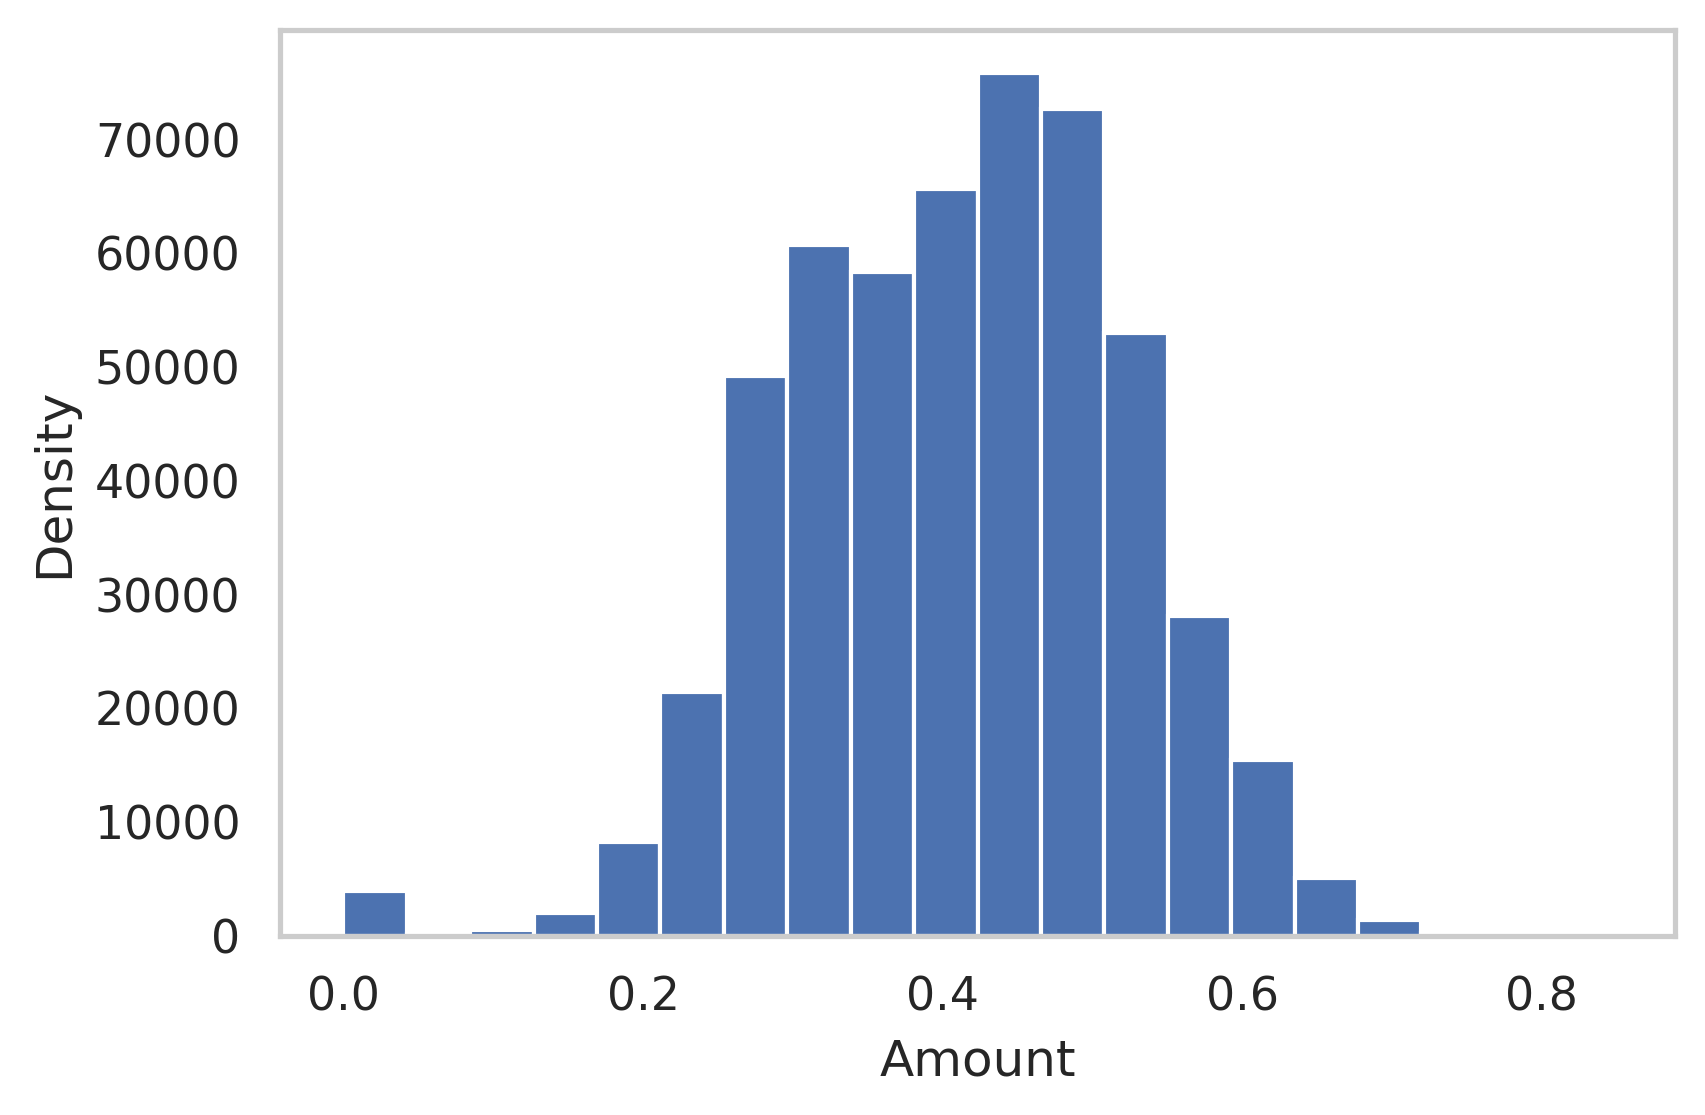

In [81]:
plt.hist(amnts, bins=20)
plt.xlabel('Amount')
plt.ylabel('Density')
plt.grid()
plt.show()

In [77]:
np.median(amnts)

0.4138191342353821

In [83]:
num_map_index = dict(zip(num_features_names, range(len(num_features_names))))

#### Next hour

In [97]:
from data_generators import num_features_names, num_features_indices
from matplotlib import pyplot as plt

In [70]:
num_map_index = dict(zip(num_features_names, range(len(num_features_names))))

In [102]:
hours = []

for batch in tqdm.tqdm(train_dataloader):
    trx_index = batch['mask'].sum(1, keepdim=True) - 1
    input_labels = torch.gather(batch['num_features'][num_map_index['hour_diff']], 1, trx_index)
    
    hours.extend(input_labels.flatten().cpu().tolist())
    

32768it [00:59, 549.57it/s] 


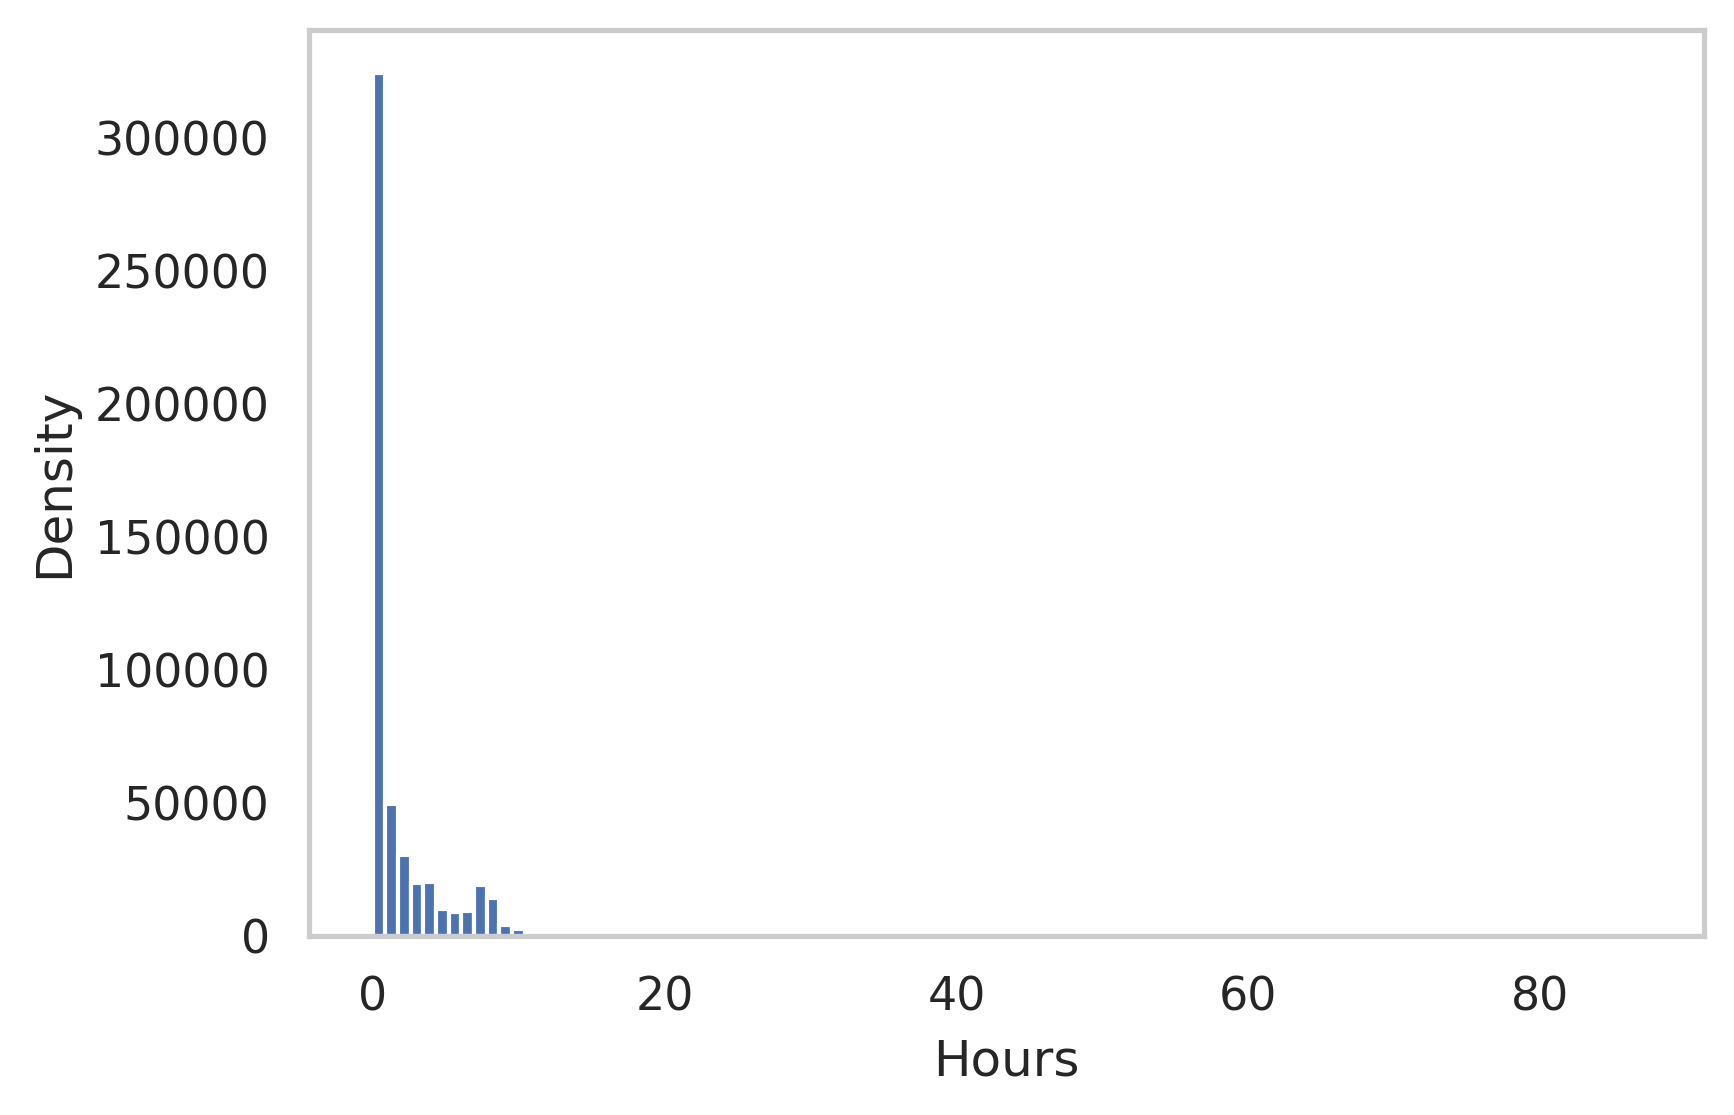

In [104]:
plt.hist(hours, bins=100)
plt.xlabel('Hours')
plt.ylabel('Density')
plt.grid()
plt.show()

In [107]:
np.median(hours) * 95

36.00000083446503

#### Next amnt 7 days

In [24]:
from data_generators import num_features_names, num_features_indices
from matplotlib import pyplot as plt

In [21]:
amount = []

for batch in tqdm.tqdm(train_dataloader):
    labels, _, _, padding_mask = make_time_batch(batch, number_days=7)
    trx_index = padding_mask.sum(1, keepdim=True) - 1
    
    if any(trx_index == -1):
        continue

    input_labels = torch.gather(labels, 1, trx_index)
    amount.extend(input_labels.flatten().cpu().tolist())

32768it [01:50, 295.55it/s]


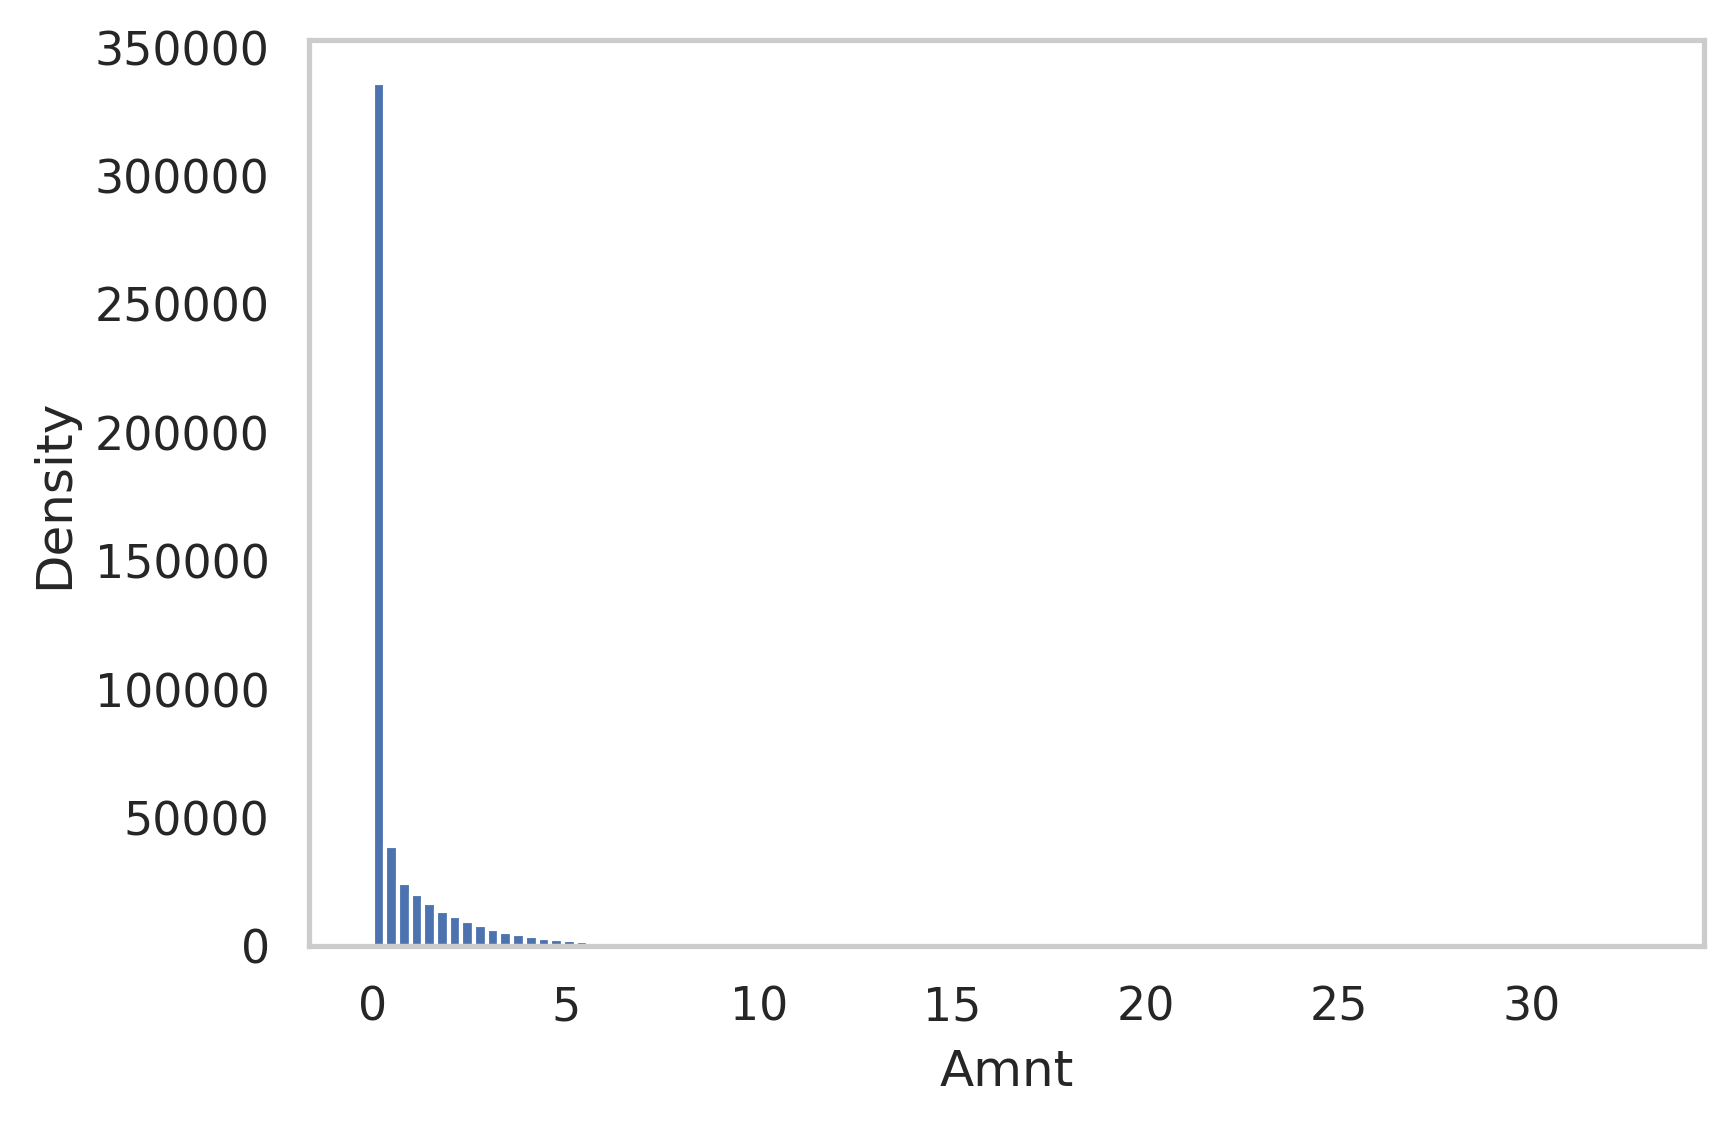

In [22]:
plt.hist(amount, bins=100)
plt.xlabel('Amnt')
plt.ylabel('Density')
plt.grid()
plt.show()

In [23]:
np.quantile(amount, 0.65)

0.33634451031684875

#### Next num 7 days

In [28]:
nums = []

for batch in tqdm.tqdm(train_dataloader):
    _, labels, _, padding_mask = make_time_batch(batch, number_days=7)
    trx_index = padding_mask.sum(1, keepdim=True) - 1
    
    if any(trx_index == -1):
        continue

    input_labels = torch.gather(labels, 1, trx_index)
    nums.extend(input_labels.flatten().cpu().tolist())

6125it [00:20, 480.25it/s]

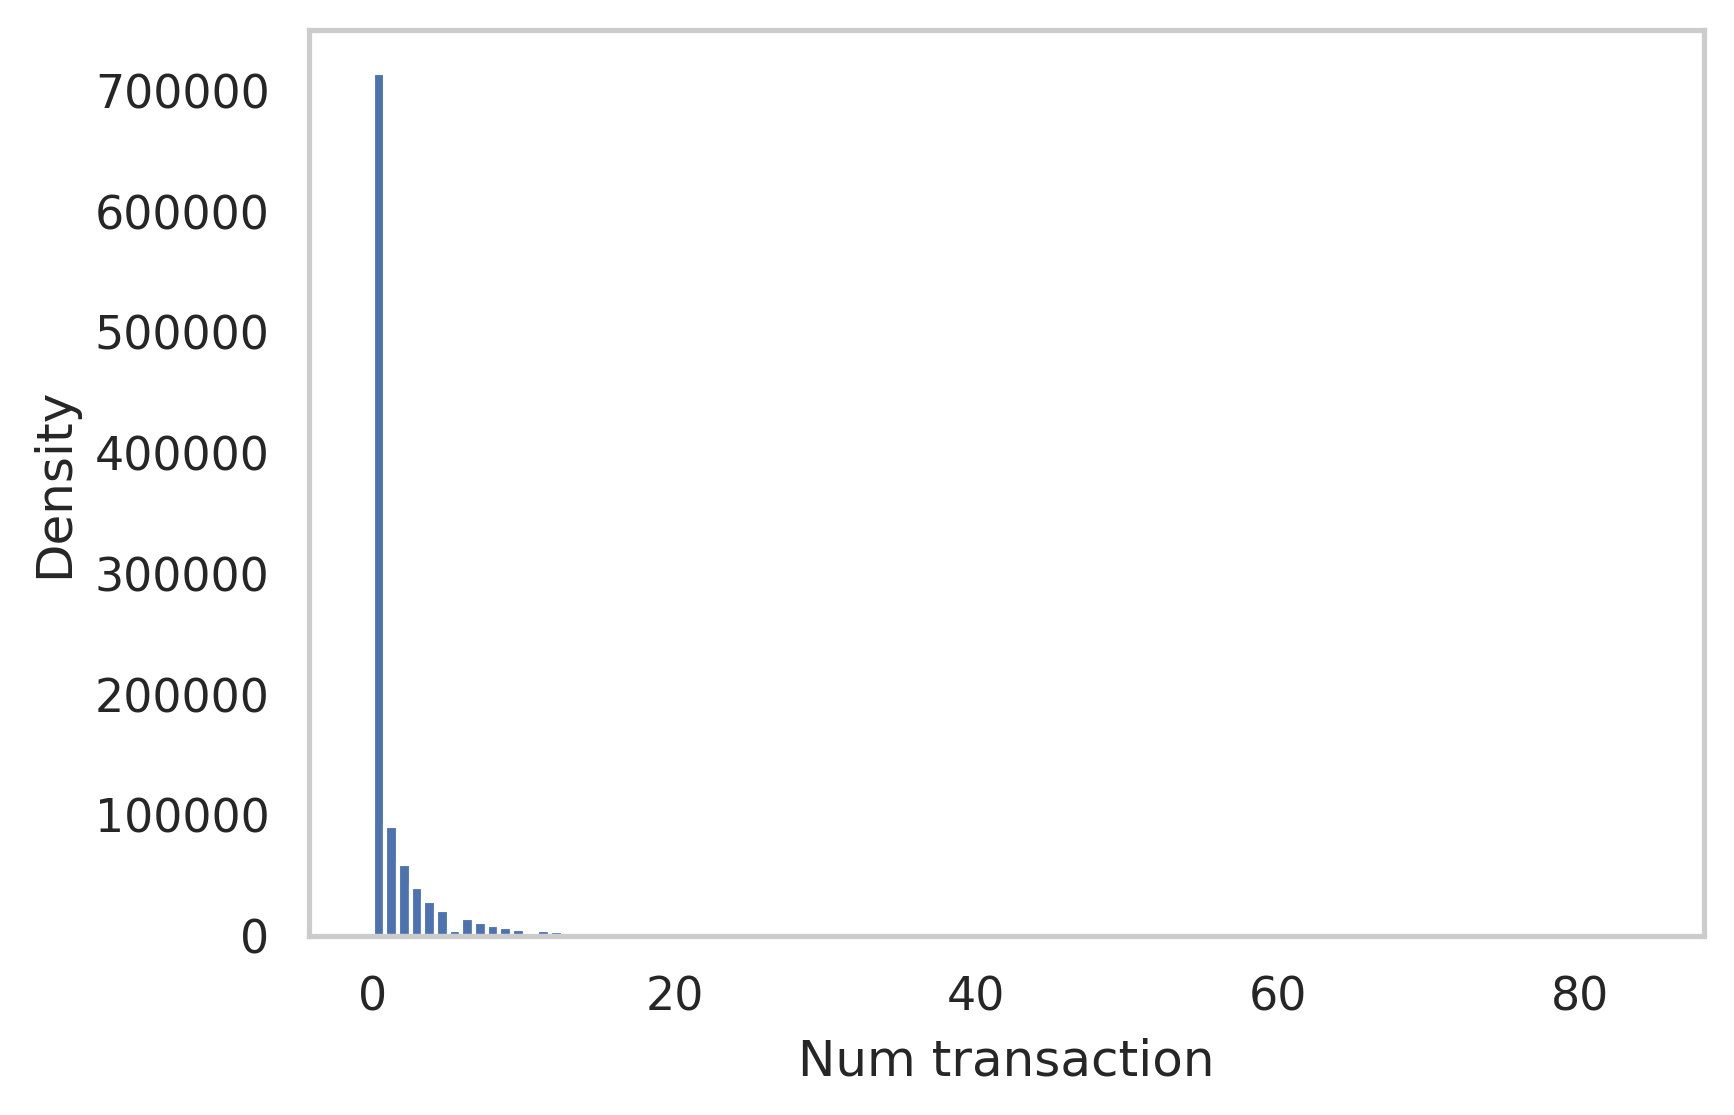

In [ ]:
plt.hist(amount, bins=100)
plt.xlabel('Num transaction')
plt.ylabel('Density')
plt.grid()
plt.show()

In [27]:
np.quantile(nums, 0.65)

0.41596387326717393

### Loading model

In [14]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pickle
import random
import numpy as np
import pandas as pd
import dataclasses
from pathlib import Path
from pprint import pprint

import torch
import transformers
import torch.nn as nn
import pytorch_lightning as pl

from torch.utils.data import IterableDataset, DataLoader

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoConfig

import tqdm 
from tqdm.notebook import tqdm

from typing import Dict, List, Optional

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
pd.set_option('display.max_columns', None)

# добавим корневую папку
sys.path.insert(1, '/home/jovyan/abdullaeva/transactionsQA')
# /Users/abdullaeva/Documents/Projects/TransactionsQA
# /home/jovyan/abdullaeva/transactionsQA
# C:/Users/airen/Documents/Projects/TransactionsQA
print(sys.path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/jovyan/romashka', '/home/jovyan/abdullaeva/transactionsQA', '', '/home/jovyan/.imgenv-afilatov-dev-6-0/lib/python3.7/site-packages', '/home/jovyan/romashka', '/home/user/conda/lib/python37.zip', '/home/user/conda/lib/python3.7', '/home/user/conda/lib/python3.7/lib-dynload', '/home/user/conda/lib/python3.7/site-packages', '/tmp/.jupyter/plugins/nb_empty_trash', '/home/user/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '../', '..']


In [17]:
from romashka.models import TransactionsModel
from romashka.tools import (make_time_batch, 
                   calculate_embedding_size)

from romashka.data_generators import (batches_generator, 
                             cat_features_names, 
                             num_features_names, 
                             meta_features_names)

from romashka.pl_dataloader import TransactionQADataset
from romashka.transactions_qa.tqa_model import TransactionQAModel
from romashka.transactions_qa.utils import get_projections_maps
from romashka.transactions_qa.tasks import AbstractTask, AutoTask

In [ ]:
projections_maps = get_projections_maps(relative_folder="../romashka")

print(f"\nCategorical embeddings projections:")   
pprint(projections_maps['cat_embedding_projections'])

print(f"\nNumeric embeddings projections:")   
pprint(projections_maps['num_embedding_projections'])

print(f"\nMeta embeddings projections:")   
pprint(projections_maps['meta_embedding_projections'])

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [44]:
ckpt = torch.load('/home/jovyan/checkpoints/checkpoints/debug-tqa_flan-t5-small_100k-steps_multichoice-6-def/last.ckpt')


In [45]:
# Loading Transactions model & weights
print(f"Loading Transactions model...")

transactions_model_encoder_type = "whisper/tiny"
transactions_model_head_type = "next"


transactions_model_config = {
    "cat_features": cat_features_names,
    "cat_embedding_projections": projections_maps.get('cat_embedding_projections'),
    "num_features": num_features_names,
    "num_embedding_projections": projections_maps.get('num_embedding_projections'),
    "meta_features": meta_features_names,
    "meta_embedding_projections": projections_maps.get('meta_embedding_projections'),
    "encoder_type": transactions_model_encoder_type,
    "head_type": transactions_model_head_type,
    "embedding_dropout": 0.1
}
transactions_model = TransactionsModel(**transactions_model_config)

Loading Transactions model...
USING whisper


In [46]:
# Configure and load from HF hub LM model
language_model_name_or_path = "google/flan-t5-small"
use_fast_tokenizer = True

print(f"Loading Language model: `{language_model_name_or_path}`...")
config_kwargs = {
    "use_auth_token": None,
    "return_unused_kwargs": True
}

tokenizer_kwargs = {
    "use_fast": use_fast_tokenizer,
    "use_auth_token": None,
    "do_lowercase": False
}

config, unused_kwargs = AutoConfig.from_pretrained(
    language_model_name_or_path, **config_kwargs
)
# Download vocabulary from huggingface.co and define model-specific arguments
tokenizer = AutoTokenizer.from_pretrained(language_model_name_or_path, **tokenizer_kwargs)

# Download model from huggingface.co and cache.
lm_model = AutoModelForSeq2SeqLM.from_pretrained(
    language_model_name_or_path,
    config=config
)

Loading Language model: `google/flan-t5-small`...


In [47]:
# Create tasks
tasks = []
task_names = ['default']
task_kwargs = [{"num_options": 6 }] # ground truth + 5 additional options

if isinstance(task_names, str):
    task_names = eval(task_names)
task_kwargs = task_kwargs
if isinstance(task_kwargs, str):
    task_kwargs = eval(task_kwargs)
print(f"Got task_names: {task_names} with task_kwargs: {task_kwargs}")

for task_i, task_name in enumerate(task_names):
    task_kwargs = task_kwargs[task_i] if task_i < len(task_kwargs) else {}
    if "tokenizer" not in task_kwargs:
        task_kwargs['tokenizer'] = tokenizer
    task = AutoTask.get(task_name=task_name, **task_kwargs)
    tasks.append(task)
print(f"Created {len(tasks)} tasks.")

2023-04-03 00:19:44,947 - [INFO] - Tasks - (task_abstract.py).extend_vocabulary(123) - Added to tokenizer: 2 tokens.
2023-04-03 00:19:44,948 - [INFO] - Tasks - (task_abstract.py).extend_vocabulary(129) - Notice: resize_token_embeddings of a model to adapt to the size of the new vocabulary!


Got task_names: ['default'] with task_kwargs: [{'num_options': 6}]
Created 1 tasks.


In [48]:
from transactions_qa.tqa_model import TransactionQAModel

# Create general Tranactions QA model
max_steps = 100_000
warmup_steps = 1000
do_freeze_transactions_model = True
do_freeze_language_model = True
do_freeze_connector = False

transactionsQA_model_config = {
    "warmup_steps": warmup_steps,
    "training_steps": max_steps,
    "do_freeze_tm": do_freeze_transactions_model,
    "do_freeze_lm": do_freeze_language_model,
    "do_freeze_connector": do_freeze_connector,
    "connector_input_size": 384,
}
model = TransactionQAModel(
    language_model=lm_model,
    transaction_model=transactions_model,
    tokenizer=tokenizer,
    tasks=tasks,
    **transactionsQA_model_config
)

2023-04-03 00:19:49,061 - [INFO] - TransactionQAModel - (tqa_model.py)._prepare_model(116) - Running in `single task` settingwith a single task: default provided.
2023-04-03 00:19:49,061 - [INFO] - TransactionQAModel - (tqa_model.py)._prepare_model(116) - Running in `single task` settingwith a single task: default provided.
2023-04-03 00:19:49,062 - [INFO] - TransactionQAModel - (tqa_model.py)._set_model_type(151) - Language model type: `encoder-decoder`
2023-04-03 00:19:49,062 - [INFO] - TransactionQAModel - (tqa_model.py)._set_model_type(151) - Language model type: `encoder-decoder`
2023-04-03 00:19:49,063 - [INFO] - TransactionQAModel - (tqa_model.py)._resize_text_embeddings(161) - LM initial `num_embeddings`: 32128, `embedding_dim`: 512
2023-04-03 00:19:49,063 - [INFO] - TransactionQAModel - (tqa_model.py)._resize_text_embeddings(161) - LM initial `num_embeddings`: 32128, `embedding_dim`: 512
2023-04-03 00:19:49,244 - [INFO] - TransactionQAModel - (tqa_model.py)._resize_text_embedd

Output dimension of embedding model: 384
Input dimension of autoregressive model: 512
Creating linear connector from 384 to 512 and move to device: cpu.


In [49]:
DATA_PATH = Path("../data").resolve()

TRAIN_BUCKETS_PATH = DATA_PATH / "train_buckets"
VAL_BUCKETS_PATH = DATA_PATH / "val_buckets"

n_train_files = len(list(TRAIN_BUCKETS_PATH.glob("*.pkl")))
print(f"Train contains files: {n_train_files} ")

n_val_files = len(list(VAL_BUCKETS_PATH.glob("*.pkl")))
print(f"Validation contains files: {n_val_files} ")

TRAIN_METAFILE_PATH = str(DATA_PATH / 'train.csv')
VAL_METAFILE_PATH = str(DATA_PATH / 'val.csv')

Train contains files: 10 
Validation contains files: 5 


In [50]:
data_files = {}

train_dataset_files = os.listdir(str(TRAIN_BUCKETS_PATH))
n_train_files = len(train_dataset_files)
print(f"Train contains files: {n_train_files}")
train_dataset_files = sorted([os.path.join(str(TRAIN_BUCKETS_PATH), x) for x in train_dataset_files])
data_files["train"] = train_dataset_files

for fn in train_dataset_files:
    print("\t", fn)

val_dataset_files = os.listdir(str(VAL_BUCKETS_PATH))
n_val_files = len(val_dataset_files)
print(f"\nVal contains files: {n_val_files}")
val_dataset_files = sorted([os.path.join(str(VAL_BUCKETS_PATH), x) for x in val_dataset_files])
data_files["validation"] = val_dataset_files

for fn in val_dataset_files:
    print("\t", fn)

Train contains files: 10
	 /home/jovyan/data/train_buckets/processed_chunk_000.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_001.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_002.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_003.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_004.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_005.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_006.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_007.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_008.pkl
	 /home/jovyan/data/train_buckets/processed_chunk_009.pkl

Val contains files: 5
	 /home/jovyan/data/val_buckets/processed_chunk_000.pkl
	 /home/jovyan/data/val_buckets/processed_chunk_001.pkl
	 /home/jovyan/data/val_buckets/processed_chunk_002.pkl
	 /home/jovyan/data/val_buckets/processed_chunk_003.pkl
	 /home/jovyan/data/val_buckets/processed_chunk_004.pkl


In [51]:
train_dataset_config = {
    'dataset': data_files['validation'],
    'min_seq_len': 0,
    'max_seq_len': 250,
    'seed': 42, 
    'buffer_size': 10_000,
}
train_ds = TransactionQADataset(**train_dataset_config).build_dataset()                                      

train_dataloader = DataLoader(train_ds, 
                                batch_size=32,
                                num_workers=4, 
                                collate_fn=TransactionQADataset.collate_fn,
                                )

In [52]:
val_dataset_config = {
    'dataset': data_files['validation'],
    'min_seq_len': 0,
    'max_seq_len': 250,
    'seed': 42, 
    'buffer_size': 0,
}

val_ds = TransactionQADataset(**val_dataset_config).build_dataset()

val_dataloader = DataLoader(val_ds, 
                                batch_size=32,
                                num_workers=4, 
                                collate_fn=TransactionQADataset.collate_fn,
                    )

In [53]:
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [54]:
ind_pos = model.tokenizer("Yes").input_ids[0]
ind_neg = model.tokenizer("No").input_ids[0]

list_targets = []
list_preds = [] 

with torch.no_grad():
    for batch in val_dataloader:
        model.eval()
        outputs, answers = model.model_step(batch)

        targets = (answers[:, -2] == ind_pos).long()
        preds = torch.sigmoid(outputs.logits[:, 0, ind_pos] - outputs.logits[:, 0, ind_neg])

        list_targets.extend(targets.tolist())
        list_preds.extend(preds.tolist())

In [65]:
targets.tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0]

In [40]:
qa_batch = tqa.add_qa2transactions(batch, 'next_amnt')
target, trx_index = tqa.get_task_label(batch)

In [31]:
targets = []
for batch in tqdm.tqdm(train_dataloader):
    qa_batch = tqa.add_qa2transactions(batch, 'next_amnt')
    target, trx_index = tqa.get_task_label(batch)
    targets.extend((target.input_ids[:, -2] == 2163).long().tolist())

32768it [01:23, 390.13it/s]


In [32]:
np.mean(targets)

1.0

In [25]:
tok.batch_decode(target.input_ids)

['No</s>',
 'Yes</s>',
 'Yes</s>',
 'Yes</s>',
 'Yes</s>',
 'Yes</s>',
 'Yes</s>',
 'No</s>',
 'Yes</s>',
 'No</s>',
 'No</s>',
 'Yes</s>',
 'Yes</s>',
 'Yes</s>',
 'Yes</s>',
 'No</s>']

In [42]:
def validate_task(model, val_dataloader, task='default'):
    list_preds = []
    list_targets = []
    list_preds_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm.tqdm(val_dataloader):
            qa_batch = tqa.add_qa2transactions(batch, task)
            outputs, answer = tqa.get_predictions(qa_batch)

            targets = (answer[:, -2] == 2163).long()
            preds = torch.sigmoid(outputs.logits[:, 0, 2163] - outputs.logits[:, 0, 465])

            list_targets.extend(batch['label'].cpu().numpy().flatten())
            list_preds.extend(preds.cpu().numpy().flatten())
            list_preds_labels.extend((preds > 0.5).long().cpu().numpy().flatten())    
            
    return list_preds, list_targets

In [43]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [44]:
res = validate_task(model, val_dataloader, 'default')

3688it [02:49, 21.81it/s]


In [28]:
roc_auc_score(res[1], res[0])

0.5000976840011366

In [45]:
import torch.nn as nn

In [50]:
tmp = nn.ModuleDict()

In [51]:
tmp['key'] = nn.Linear(1, 1)

In [52]:
tmp

ModuleDict(
  (key): Linear(in_features=1, out_features=1, bias=True)
)

### Distributed DataLoader

Короче нужно вернуть старый итератор и сравнить сколько это по скорости работает?

In [11]:
from data_generators import batches_generator, old_batches_generator
from datasets import IterableDataset as HFIterableDataset
from pl_dataloader import TransactionQADataset
from torch.nn.utils.rnn import pad_sequence

In [6]:
%%time
for elem in tqdm.tqdm(old_batches_generator(dataset_train, batch_size=32, min_seq_len=50, max_seq_len=150)):
    pass

7392it [01:23, 89.03it/s] 

CPU times: user 16.1 s, sys: 39.2 s, total: 55.2 s
Wall time: 1min 23s


In [7]:
ds = TransactionQADataset(dataset_train, batch_size=1, max_seq_len=150, min_seq_len=50).build_dataset(buffer_size=None)
ds2 = TransactionQADataset(dataset_train, batch_size=2, max_seq_len=150, min_seq_len=50).build_dataset(buffer_size=None)

In [12]:
def collate_fn(batch):
    output = {}

    output['num_features'] = pad_sequence([d['num_features'].transpose(0, -1) for d in batch], batch_first=True).squeeze(2).permute(-1, 0, 1)
    output['cat_features'] = pad_sequence([d['cat_features'].transpose(0, -1) for d in batch], batch_first=True).squeeze(2).permute(-1, 0, 1)
    output['meta_features'] = torch.cat([d['meta_features'] for d in batch], dim=1)

    output['mask'] = pad_sequence([d['mask'].transpose(0, -1) for d in batch], batch_first=True).squeeze(2)
    output['app_id'] = torch.cat([d['app_id'] for d in batch])
    output['label'] = torch.cat([d['label'] for d in batch])

    return output

In [13]:
my_dl = DataLoader(ds, batch_size=32, num_workers=10, collate_fn=collate_fn)
my_dl2 = DataLoader(ds, batch_size=32, num_workers=1, collate_fn=collate_fn)
my_dl3 = DataLoader(ds2, batch_size=16, num_workers=10, collate_fn=collate_fn)

In [14]:
%%time
for elem in tqdm.tqdm(my_dl):
    pass

7336it [00:28, 257.34it/s]

CPU times: user 10.1 s, sys: 5.59 s, total: 15.7 s
Wall time: 28.5 s


In [23]:
# Download vocabulary from huggingface.co and define model-specific arguments
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-small')

config = AutoConfig.from_pretrained(
    'google/flan-t5-small',
)

# Download model from huggingface.co and cache.
lm_model = AutoModelForSeq2SeqLM.from_pretrained(
    'google/flan-t5-small',
    config=config
)

In [ ]:
transactions_model_config = {
    "cat_features": cat_features_names,
    "cat_embedding_projections": projections_maps.get('cat_embedding_projections'),
    "num_features": num_features_names,
    "num_embedding_projections": projections_maps.get('num_embedding_projections'),
    "meta_features": meta_features_names,
    "meta_embedding_projections": projections_maps.get('meta_embedding_projections'),
    "encoder_type": model_args.transactions_model_encoder_type,
    "head_type": model_args.transactions_model_head_type,
    "embedding_dropout": 0.1
}
transactions_model = TransactionsModel(**transactions_model_config)

In [ ]:
# Create general Tranactions QA model
transactionsQA_model_config = {
    "warmup_steps": 10,
    "training_steps": 1000,
    "do_freeze_tm": False,
    "do_freeze_lm": False,
    "do_freeze_connector": False,
    "connector_input_size": 384,
}
model = TransactionQAModel(
    language_model=lm_model,
    transaction_model=transactions_model,
    tokenizer=tokenizer,
    tasks=tasks,
    **transactionsQA_model_config
)

### Saving new data format

In [ ]:
path = dataset_train[0]

gc.disable()
with open(path, 'rb') as f:
    data = pickle.load(f)

gc.enable()

padded_sequences, targets, products = data['padded_sequences'], data['targets'], data[
    'products']
app_ids = data['app_id']
indices = np.arange(len(products))

transaction_features = ['currency', 'operation_kind', 'card_type', 'operation_type',
                        'operation_type_group', 'ecommerce_flag', 'payment_system',
                        'income_flag', 'mcc', 'country', 'city', 'mcc_category',
                        'day_of_week', 'hour', 'weekofyear', 'amnt', 'days_before', 'hour_diff']

num_features_names = ['amnt', 'days_before', 'hour_diff']
cat_features_names = [x for x in transaction_features if x not in num_features_names]
meta_features_names = ['product']

num_features_indices = [transaction_features.index(x) for x in num_features_names]
cat_features_indices = [transaction_features.index(x) for x in cat_features_names]


bucket = padded_sequences[0]
batch_sequences = bucket[0: 0 + 1]

new_data = {}

for key in data:
    for elem in data[key]:
        new_data[key] = to

                        ret = dict(num_features=[torch.FloatTensor(batch_sequences[:, i]) for i in num_features_indices],
                            cat_features=[torch.LongTensor(batch_sequences[:, i]) for i in cat_features_indices],
                            mask=torch.BoolTensor(mask),
                            meta_features=[torch.LongTensor(batch_products)],
                            app_id=torch.LongTensor(batch_app_ids)
                )

### Chill

In [10]:
from pl_dataloader import TransactionQADataset

In [11]:
val_ds = TransactionQADataset(dataset_val)

val_dataloader = DataLoader(val_ds, 
                                batch_size=32,
                                num_workers=8, 
                                shuffle=False,
                                collate_fn=TransactionQADataset.collate_fn
                            )

In [12]:
#  def __iter__(self):
#         worker_total_num = torch.utils.data.get_worker_info().num_workers
#         worker_id = torch.utils.data.get_worker_info().id
#         #Create an iterator
#         file_itr = open(self.filename)

#         #Map each element using the line_mapper
#         mapped_itr = map(self.line_mapper, file_itr)
        
#         #Add multiworker functionality
#         mapped_itr = islice(mapped_itr, worker_id, None, worker_total_num)

#         return mapped_itr

In [13]:
# from itertools import islice

# it = range(1, 10)

# for elem in islice(it, 0, None, 2):
#     print(elem)